In [10]:
import numpy as np
from scipy.stats import multivariate_normal

In [11]:

class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, 0] = self.initial_prob[:, 0] * observation_matrix[:, 0]
            else:
                alpha[:, t] = (self.transition_matrix.T @ alpha[:, t-1]) * observation_matrix[:, t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = self.transition_matrix @ (beta[:,t+1] * observation_matrix[:,t+1])
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = alpha[:,t] @ ((beta[:,t+1] * B[:,t+1]).T * self.transition_matrix)
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = gamma[:, 0].reshape(-1,1)
        expected_transition = self._stochasticize(xi_sum)

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        # self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from glob import glob
import librosa
import librosa.display

In [13]:
TOP_DB = 40
MFCC_SIZE = 39
TEST_SIZE = 0.2

## Read file

In [14]:
audio_files = sorted(glob('./recordings/*'))

In [15]:
import re

text = audio_files[300]
pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

result = re.search(pattern, text)
groups = result.groups()
dictionary = {
    'number': int(groups[0]),
    'name': groups[1],
    'order': int(groups[2])
}
dictionary

{'number': 1, 'name': 'george', 'order': 0}

In [16]:
def convert_path_to_dict(path):
    pattern = r'(\d+)_([a-zA-Z]+)_(\d+)\.wav'

    result = re.search(pattern, path)
    groups = result.groups()
    return {
        'number': int(groups[0]),
        'name': groups[1],
        'order': int(groups[2])
    }
convert_path_to_dict(audio_files[300])

{'number': 1, 'name': 'george', 'order': 0}

## MFCC

In [17]:
def analyse_audio(path):
    output = convert_path_to_dict(path)
    y, sr = librosa.load(path)
    y_tr, index = librosa.effects.trim(y, top_db=TOP_DB)
    mfcc = np.array(librosa.feature.mfcc(y=y_tr, sr=sr, n_mfcc=13))
    output['sr'] = sr
    output['y'] = y
    output['y trim'] = y_tr
    # ? we use transfer mfcc
    output['mfcc'] = mfcc.T
    return output
print([len(i) for i in analyse_audio(audio_files[0])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[1])['mfcc']])
print([len(i) for i in analyse_audio(audio_files[2])['mfcc']])

[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]
[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13]


In [18]:
output_list = [analyse_audio(file) for file in audio_files]
df = pd.DataFrame(output_list)
df[:3]

,number,name,order,sr,y,y trim,mfcc
0,0,george,0,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-633.7214, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0..."
1,0,george,1,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-643.057, 25.02723, 23.553139, 21.222677, 18..."
2,0,george,10,22050,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[-638.5822, -0.03040633, -19.927683, -0.31883..."


## Create hmm

In [19]:
def create_test_and_train_data(df, par_main, par_side, test_percent=TEST_SIZE):
    '''[par_main][par_side] = mfcc'''
    training_data = dict()
    testing_data = dict()
    for i in df[par_main].unique():
        train_tmp = []
        test_tmp = []
        for j in df[par_side].unique():
            filtered_data = np.array(df[(df[par_main] == i) & (df[par_side] == j)]['mfcc'])
            test_size = int(len(filtered_data) * test_percent)
            train_tmp.append(filtered_data[:-test_size])
            test_tmp.append(filtered_data[-test_size:])
        training_data[i] = np.concatenate(train_tmp)
        testing_data[i] = np.concatenate(test_tmp)
    return training_data, testing_data

In [20]:
def train_data(data:dict, n_com=3) -> dict:
    hmms = dict()
    for num in data.keys():
        concatenate_data = np.concatenate(np.array(data[num])).T
        new_hmm = HMM(num_hidden_states=n_com)
        new_hmm.train(concatenate_data, num_iterations=10)
        hmms[num] = new_hmm
    return hmms

In [21]:
def test_hmm(data:dict, hmms:dict) -> dict:
    result = dict()
    for i in data.keys():
        result[i] = []
        for j in data[i]:
            tmp = dict()
            for k in hmms.keys():
                tmp[k] = hmms[k].score(j.T)
            q = max(tmp, key=lambda k: tmp[k])
            result[i].append(q)
    return result

In [22]:
def draw_confusion(confusion_df):
    ax = sns.heatmap(confusion_df, annot=True, linewidth=0.5, fmt='0')
    ax.set(xlabel="label", ylabel="result")
    ax.invert_yaxis()

In [23]:
def calculate_confusion(result):
    result_matrix = {i:
        {j:
            result[i].count(j)
            for j in result.keys()} 
        for i in result.keys()}
    return pd.DataFrame(result_matrix)

In [24]:
def convert_confusion_to_T_F_P_N(confusion_df):
    confusion_matrix = confusion_df.to_numpy()
    m = {list(result.keys())[i]:
        {
            'TP': confusion_matrix[i,i],
            'FP': np.sum(confusion_matrix[i,:]) - confusion_matrix[i,i],
            'FN': np.sum(confusion_matrix[:,i]) - confusion_matrix[i,i]
        }
        for i in range(len(list(result.keys())))}
    return pd.DataFrame(m).transpose()

In [25]:
def calculate_score(T_F_P_N_df, confusion_df):
    precision = T_F_P_N_df['TP'] / (T_F_P_N_df['TP'] + T_F_P_N_df['FP'])
    recall = T_F_P_N_df['TP'] / (T_F_P_N_df['TP'] + T_F_P_N_df['FN'])
    f1 = 2 * precision * recall / (precision + recall)
    return pd.DataFrame({'f1': f1, 'precision': precision, 'recall': recall})

In [26]:
def calculate_micro_macro(df, confusion_df):
    confusion_matrix = confusion_df.to_numpy()
    accuracy = np.sum(np.diagonal(confusion_matrix)) / np.sum(confusion_matrix)
    
    out = {'macro':{
        'accuracy': accuracy,
        'precision': np.mean(df['precision']),
        'recall': np.mean(df['recall'])
    },
     'micro':{
        'accuracy': accuracy,
        'precision': np.sum(df['TP']) / (np.sum(df['TP']) + np.sum(df['FP'])),
        'recall': np.sum(df['TP']) / (np.sum(df['TP']) + np.sum(df['FN']))
    }}
    
    for i in out.keys():
        out[i]['f1'] = 2 * out[i]['precision'] * out[i]['recall'] / (out[i]['precision'] + out[i]['recall'])
    return pd.DataFrame(out).transpose()

In [27]:
def analyse_result(result):
    confusion_df = calculate_confusion(result)
    draw_confusion(confusion_df)
    T_F_P_N_df = convert_confusion_to_T_F_P_N(confusion_df)
    score_df = calculate_score(T_F_P_N_df, confusion_df)
    df = pd.concat([T_F_P_N_df, score_df], axis=1)
    total_df = calculate_micro_macro(df, confusion_df)
    display(df)
    display(total_df)

## Test

,TP,FP,FN,f1,precision,recall
0,57,9,3,0.904762,0.863636,0.950000
1,58,5,2,0.943089,0.920635,0.966667
2,52,1,8,0.920354,0.981132,0.866667
3,46,2,14,0.851852,0.958333,0.766667
4,59,1,1,0.983333,0.983333,0.983333
5,54,2,6,0.931034,0.964286,0.900000
6,51,11,9,0.836066,0.822581,0.850000
7,60,11,0,0.916031,0.845070,1.000000
8,58,6,2,0.935484,0.906250,0.966667
9,56,1,4,0.957265,0.982456,0.933333


,accuracy,precision,recall,f1
macro,0.918333,0.922771,0.918333,0.920547
micro,0.918333,0.918333,0.918333,0.918333


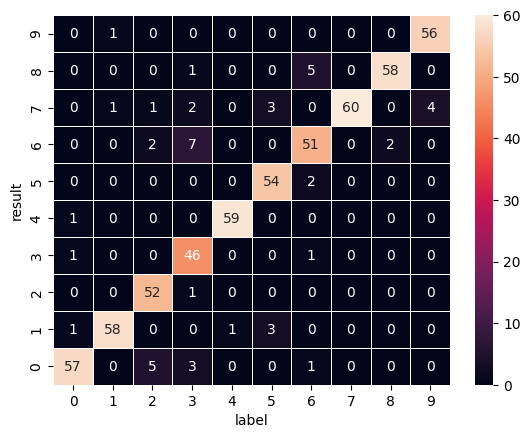

In [28]:
training_data, testing_data = create_test_and_train_data(df, 'number', 'name')
hmms = train_data(training_data, n_com=10)
result = test_hmm(testing_data, hmms)
analyse_result(result)

,TP,FP,FN,f1,precision,recall
george,100,8,0,0.961538,0.925926,1.00
jackson,92,0,8,0.958333,1.000000,0.92
lucas,100,0,0,1.000000,1.000000,1.00
nicolas,100,0,0,1.000000,1.000000,1.00
theo,89,1,11,0.936842,0.988889,0.89
yweweler,99,11,1,0.942857,0.900000,0.99


,accuracy,precision,recall,f1
macro,0.966667,0.969136,0.966667,0.967900
micro,0.966667,0.966667,0.966667,0.966667


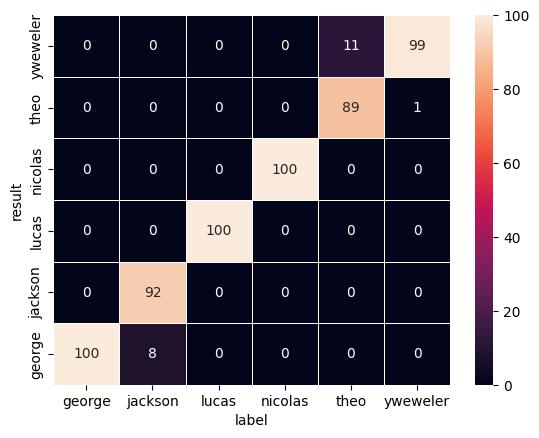

In [29]:
training_data, testing_data = create_test_and_train_data(df, 'name', 'number')
hmms = train_data(training_data, n_com=10)
result = test_hmm(testing_data, hmms)
analyse_result(result)